# Reduction and calibration script for long-slit spectra

In [1]:
__main__ = 'Manual_reduction_spectra'
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '0.2'
__keywords__ = ['astronomy', 'spectroscopy', 'astropy', 'specutils', 'specreduce', 'matplotlib']
#import sys, numpy, matplotlib
#print('Python ' + sys.version)
#print('matplotlib ' + str(sys.modules['matplotlib'].__version__))
#print('numpy ' + str(sys.modules['numpy'].__version__))
#!jupyter --version


## Configuration

In [60]:
#dir = 'e:/Astro/Captures/20231008_Void/'
dir = '../../../CAPTURES/OHP2024/20240710/'
#dir = 'E:/Astro/Captures/20161006_tp_spectro_L3/'

# CALC
#obs_latitude = 47.89
#obs_longitude = -1.50

#OHP
obs_longitude = 5.7122222222222225
obs_latitude = 43.9316667

#bias = 'Bias'
bias = 'offset-*'
#darks = 'dark-*'
darks = 'noir-600-*'
flats = 'flat-*'
calibs = 'neon-*'
#sciences = 'agdra-*'
#target = 'agdra'
sciences = '10lac-*'
target = '10lac'

#sciences = 'hd158460-*'
#target = 'hd158460'

#sciences = 'ngc6543'
#sciences = 'deneb'

#trim_region = '600, 600, 2700, 1400'              # x1, y1, x2, y2 
trim_region = None

masterbias = 'masterbias.fit'
masterdark = 'masterdark.fit'
masterflat = 'masterflat.fit'
mastercalib = 'mastercalib.fit'
masterresponse = 'response.fit'

memory_limit = 1e9               # how much memory (bytes) to allocate to combine operations ?

#camera_electronic_gain = 1.2     # asi 183mm
#camera_readout_noise = 2.2       # asi 183mm

camera_electronic_gain = 0.13    # atik 420m 
camera_readout_noise = 3.0       # atik 420m

#camera_electronic_gain = 0.27    # atik 460m 
#camera_readout_noise = 5.0       # atik 460m

## Imports libs

In [3]:
%matplotlib widget
import warnings, fnmatch, os
from time import gmtime, strftime
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, QTable
from astropy import units as u
from astropy.nddata import CCDData, StdDevUncertainty
from astropy.stats import mad_std
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning

from ccdproc import Combiner, combine, subtract_bias, subtract_dark, flat_correct
from ccdproc import trim_image, Combiner, ccd_process, cosmicray_median

from align_combine import align_and_combine

warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', UserWarning)


## Create logger

In [4]:
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')

## Create masters

### Bias

### Darks

### Flats

### Calibration

## Process science files

### Reduce

### Align and combine

### Remove cosmic rays

### Display

## Create spectra 

### Extract science spectra

In [13]:
### run if spectra free of cosmics is to be used 
#master_science = sci_cleaned.data

2024-07-22 18:20:41 [INFO] - extracting science spectra...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-07-22 18:20:41 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
2024-07-22 18:20:41 [INFO] - using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-07-22 18:20:41 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Text(87.59722222222221, 0.5, 'ADU')

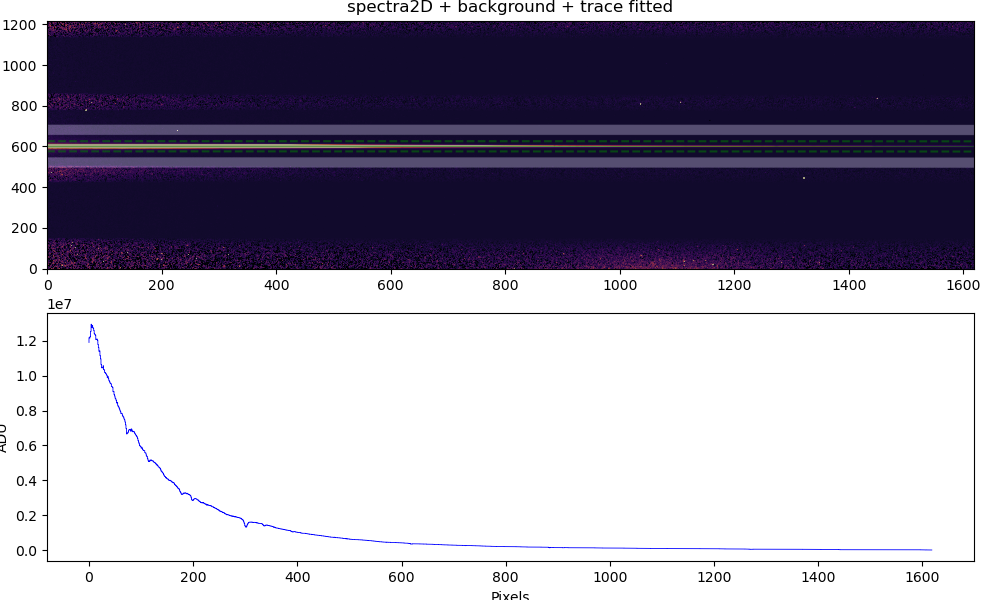

In [12]:
from astropy.modeling import models
from specreduce import tracing, background, extract

logger.info('extracting science spectra...')

master_science = CCDData.read(dir + '' + target + '.fit', unit = u.adu)
master_science_cosmic = CCDData.read(dir + '' + target + '_clean' + '.fit', unit = u.adu)
master_calib = CCDData.read(dir + mastercalib, unit = u.adu)

#sci_tr = tracing.FlatTrace(master_science, 407)
sci_tr = tracing.FitTrace(master_science,  bins = 64, trace_model=models.Polynomial1D(degree=2), peak_method = 'gaussian', window = 50) #, guess=407)
#trace_model : one of Chebyshev1D, Legendre1D, Polynomial1D, or Spline1D
#peak_method : One of gaussian, centroid, or max. gaussian
bg = background.Background.two_sided(master_science, sci_tr, separation=80, width=50) 
extract = extract.BoxcarExtract(master_science - bg, sci_tr, width = 25)
sci_spectrum = extract()

cuts = (5, 99.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
plt.tight_layout()

im = ax0.imshow(master_science, origin='lower', aspect='auto', cmap=plt.cm.magma)
ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.3)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace , color='g', linewidth = '0.3')
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.set_title('spectra2D + background + trace fitted')

ax1.step(sci_spectrum.spectral_axis , sci_spectrum.flux, color='b', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')


### Extract calibration spectra

2024-07-22 18:20:59 [INFO] - extracting neon spectrum...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-07-22 18:20:59 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


(0.0, 100000.0)

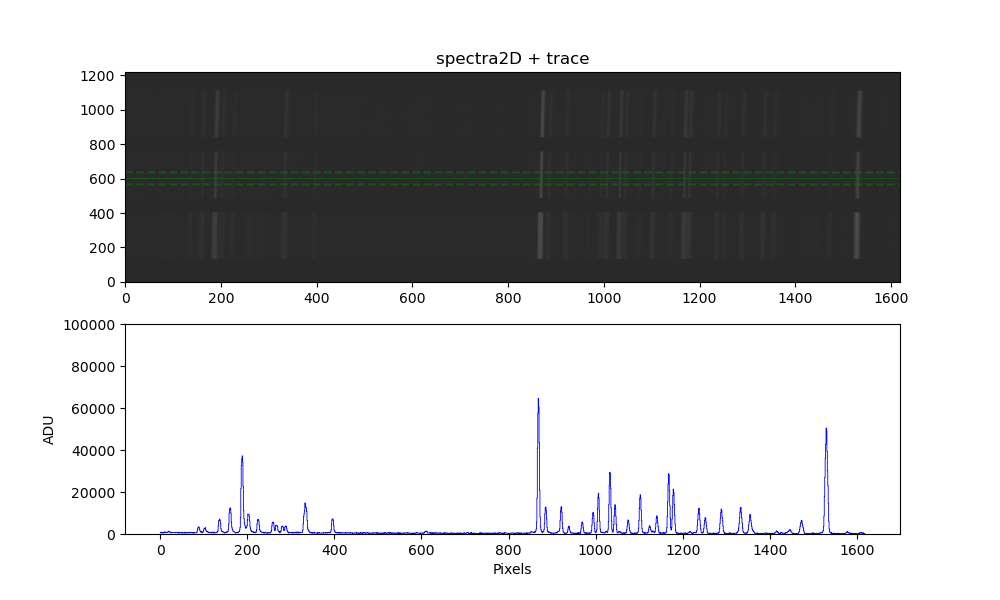

In [13]:
from astropy.modeling import models
from specreduce import tracing, background, extract

logger.info('extracting neon spectrum...')

neon_data = CCDData.read(dir + mastercalib, unit = u.adu)

#specreduce.tracing.ArrayTrace(image: NDData, trace: ndarray)
#neon_tr = tracing.FlatTrace(neon_data,sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#neon_tr = tracing.ArrayTrace(neon_data, sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#bg = background.Background.two_sided(neon_data, sci_tr, separation=50, width=0) 
extract = extract.BoxcarExtract(neon_data , sci_tr, width = 35)
neon_spectrum = extract()

cuts = (5, 98.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
#plt.tight_layout()

im = ax0.imshow(neon_data, origin='lower', aspect='auto', cmap=plt.cm.grey)
#ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace , color='g', linewidth = '0.3')
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)

ax0.set_title('spectra2D + trace')

ax1.step(neon_spectrum.spectral_axis , neon_spectrum.flux, color='b', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')
ax1.set_ylim(0, 0.1e6)


### Calibrate spectra

2024-07-22 18:25:11 [INFO] - calibrating neon spectrum...
residuals : [ 1.00693294 -1.64079547  0.49734842  0.41786375 -0.28134963] Angstrom
fitted  Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                c1                   c2          
         Angstrom       Angstrom / pix      Angstrom / pix2    
    ----------------- ------------------ ----------------------
    4338.697385565343 1.7120829046028958 2.9092885976228568e-05


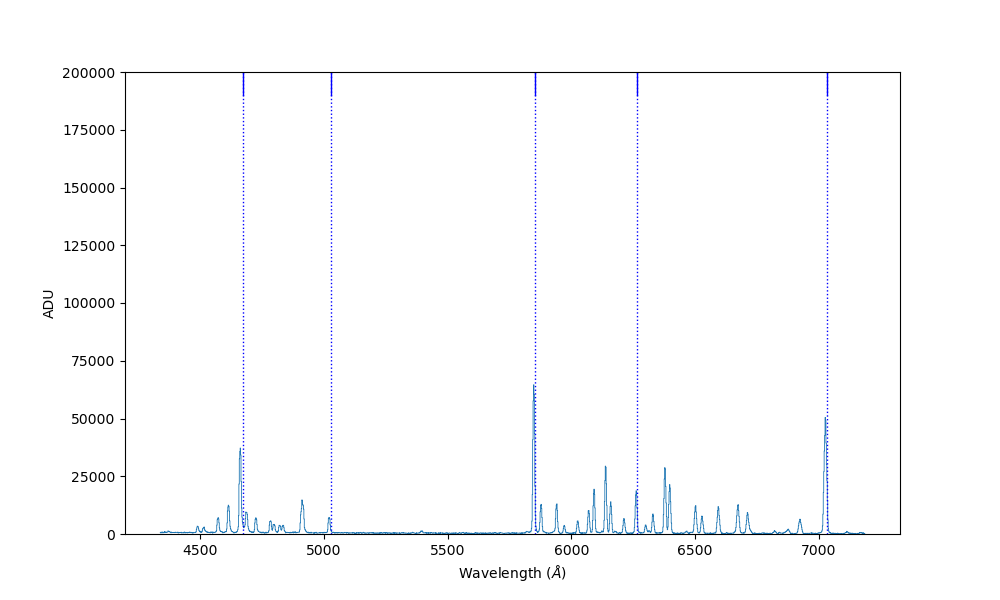

In [20]:
import astropy.units as u
from astropy.modeling import models, fitting
from specreduce import WavelengthCalibration1D

logger.info('calibrating neon spectrum...')

### alpy-600
#pixels = [351, 589, 1045, 1403, 1885, 2073]*u.pix
#wavelength = [4200.67, 4764.87, 5852.49, 6677.28, 7272.94, 7635.11]*u.AA
#pixels =     [355,     1045,    1171     , 1284,   1406,      1535  , 1674  , 1840 ]*u.pix
#wavelength = [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]*u.AA
#wavelength_ = wavelength #= [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]

# Dados
pixels = [193, 401, 871, 1105, 1533]*u.pix
wavelength = [4671.22, 5028.28, 5852.49, 6266.49, 7031.41]*u.AA

### StarEx-2400
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

### DADOS-200
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

#line_list = QTable([pixels, wavelength], names=["pixel_center", "wavelength"])
#input_spectrum, matched_line_list=None, line_pixels=None, line_wavelengths=None, catalog=None, input_model=Linear1D(), fitter=None
cal = WavelengthCalibration1D(input_spectrum = neon_spectrum,
      #matched_line_list = line_list,
      line_wavelengths = wavelength,
      line_pixels = pixels,
      input_model = models.Polynomial1D(degree = 2),
      #fitter = fitting.LMLSQFitter()
     )
print('residuals :', cal.residuals )
print('fitted ', cal.fitted_model )

neon_calibrated_spectrum = cal.apply_to_spectrum(neon_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.step(neon_calibrated_spectrum.spectral_axis, neon_calibrated_spectrum.flux, linewidth = '0.6')  
for line in wavelength:
    plt.axvline(line.value, 0.95, 1.0, color = 'b', lw = 1.0)
    plt.axvline(line.value, color = 'b', lw = 1.0, linestyle = ':')
plt.ylim(0, 0.2e6);


### Apply to science spectra

2024-07-22 18:25:28 [INFO] - calibrating science spectra...


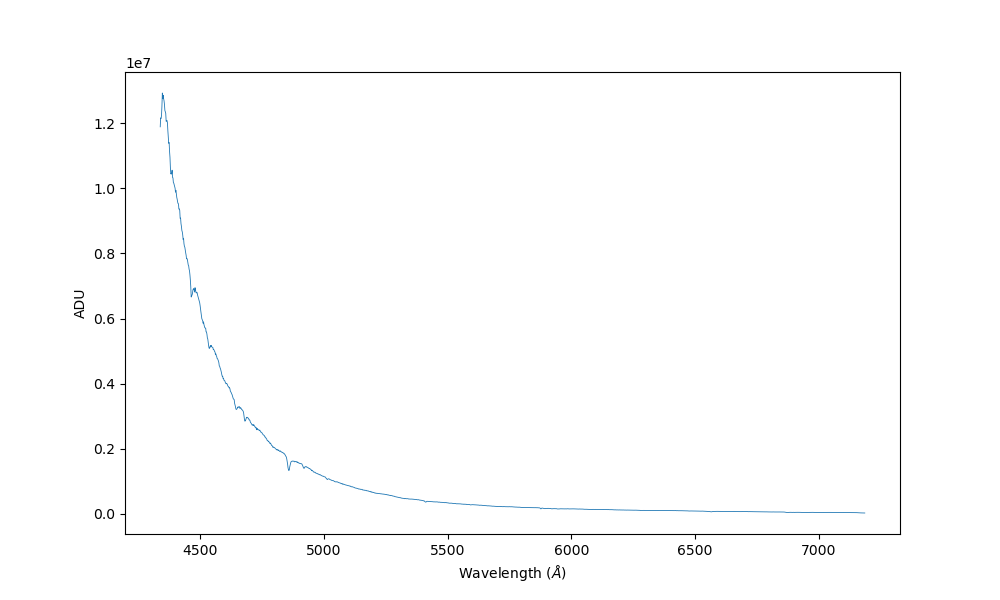

In [21]:
logger.info('calibrating science spectra...')
sci_calibrated_spectrum = cal.apply_to_spectrum(sci_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.plot(sci_calibrated_spectrum.wavelength, sci_calibrated_spectrum.flux, linewidth = '0.6');


### Correct instrument response & airmass

In [23]:
from astropy.coordinates import get_sun, AltAz, EarthLocation
from astropy.coordinates import SpectralCoord, SkyCoord
from astropy.time import Time

### compute zenith distance (if not present in fit header)
#target = '10 Lac'
target_coord = SkyCoord.from_name(target)
target_time = Time(master_science.header['DATE-OBS'])
obs_coord = EarthLocation(lon = obs_longitude * u.deg, lat = obs_latitude * u.deg)
altaz = AltAz(obstime=target_time, location = obs_coord)

ZD = target_coord.transform_to(AltAz(obstime = target_time, location = obs_coord)).zen
airmass = 1.0 / np.cos(ZD)
logger.info(f'computed ZD={ZD}, airmass={airmass}')


2024-07-22 18:26:29 [INFO] - computed ZD=39.70140502979402 deg, airmass=1.2997412762210752


Format Read Write Auto-identify
------ ---- ----- -------------
  fits  Yes   Yes           Yes
2024-07-22 19:56:04 [INFO] - reusing existing response file ... : response.fit


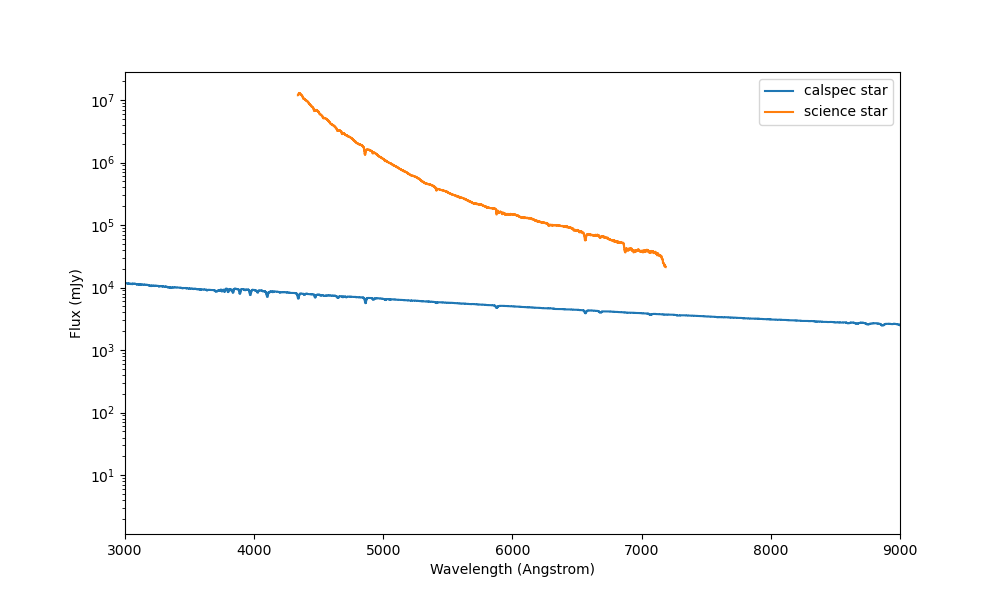

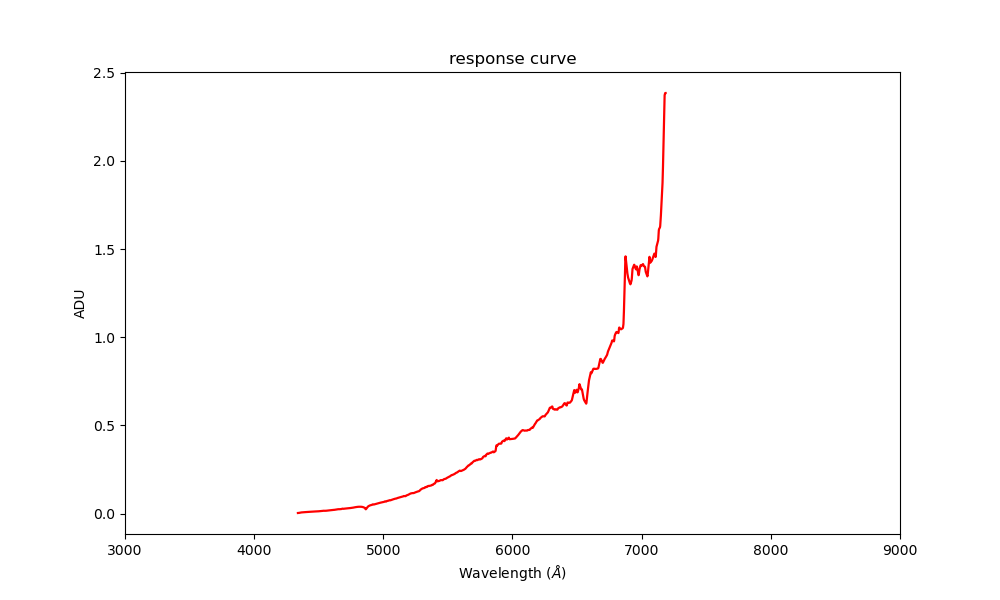

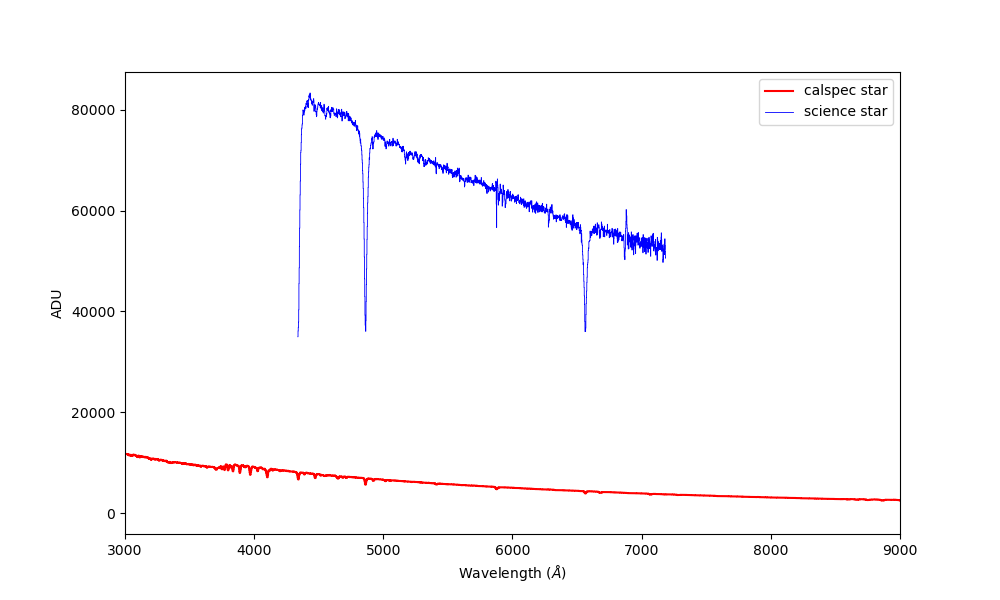

In [85]:
import matplotlib.pyplot as plt
from specreduce.calibration_data import load_MAST_calspec, load_onedstds
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import StdDevUncertainty
from specreduce.fluxcal import FluxCalibration
from specutils.manipulation import extract_region, gaussian_smooth, convolution_smooth, median_smooth
from astropy.coordinates import SpectralCoord, SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.convolution import Box1DKernel
from astropy.modeling import models, fitting
from specutils.fitting import fit_generic_continuum
import astropy.wcs as fitswcs

#std_spec = load_onedstds(dataset = 'spec50cal', specfile = 'hd217086.dat')
#std_spec = load_onedstds(dataset = 'bstdscal', specfile = 'hr5511.dat')
#std_spec = load_MAST_calspec("delumi_stis_004.fits")
std_spec = load_MAST_calspec("hd93521_stis_007.fits")

#std_spec = load_MAST_calspec("bd60d1753_stiswfc_004.fits")

#std_slice = std_spec[3800*u.AA:8200*u.AA]
#sci_slice = sci_calibrated_spectrum[3800*u.AA:8200*u.AA]

std_slice = std_spec
sci_slice = sci_calibrated_spectrum


fig, ax = plt.subplots(figsize=(10,6))
plt.xlim(3000, 9000)
ax.step(std_slice.spectral_axis, std_slice.flux, where="mid", label = 'calspec star')
ax.step(sci_slice.spectral_axis, sci_slice.flux, where="mid", label = 'science star')
ax.set_yscale('log')
ax.set_xlabel(f"Wavelength ({std_slice.spectral_axis.unit})")
ax.set_ylabel(f"Flux ({std_slice.flux.unit})");
plt.legend(loc=('best'))

obj_spectrum = Spectrum1D(spectral_axis = sci_slice.spectral_axis, flux = sci_slice.flux)
sci_spectrum = FluxCalibration(obj_spectrum, airmass = airmass) 

### reuse existing response file
if os.path.exists(dir + masterresponse):
    logger.info('reusing existing response file ... : ' + masterresponse)
    with fits.open(dir + masterresponse) as file:
        specdata = file[1].data
        header = file[1].header
        responsefunc = Spectrum1D(flux = specdata['flux'] * u.mJy, spectral_axis = specdata['wavelength'] * u.AA)
        final_spec = sci_spectrum.apply_sensfunc(responsefunc)
else:
    logger.info('creating a new response file ... : ' + masterresponse)
    responsefunc = sci_spectrum.standard_sensfunc(
        standard = std_slice,
        mode = 'linear',
        polydeg = 2,
        #badlines=[7516, 6563, 4861, 4341],
        #badlines=[7516, 6883, 4861, 4341],
        display = False)
    final_spec = sci_spectrum.apply_sensfunc(responsefunc)
    responsefunc.write(dir + masterresponse, overwrite = True)

final_spec.write(dir + 'final-1D-' + target + '.fit', overwrite = True)
#CCDData.write(ccd_data = final_spec, filename = dir + 'final-1D-' + target + '.fit', as_image_hdu = True, format = 'wcs1d-fits')

plt.figure(figsize=(10,6))
plt.xlim(3000, 9000)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.plot(responsefunc.wavelength, responsefunc.flux, linewidth = '1.6', color = 'r');
plt.title('response curve')


plt.figure(figsize=(10,6))
plt.xlim(3000, 9000)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
#plt.step(obj_spectrum.wavelength, obj_spectrum.flux, linewidth = '0.6', color = 'black');
plt.step(std_slice.spectral_axis, std_slice.flux, color = 'r', where="mid", label = 'calspec star')
plt.step(final_spec.wavelength, final_spec.flux, linewidth = '0.6', where="mid", color = 'b', label = 'science star');
plt.legend(loc=('best'))
#plt.step(std_spec.wavelength, std_spec.flux + 5000 * u.mJy, linewidth = '0.6', color = 'r')




## Analyse spectra

### Median smooth (optional)

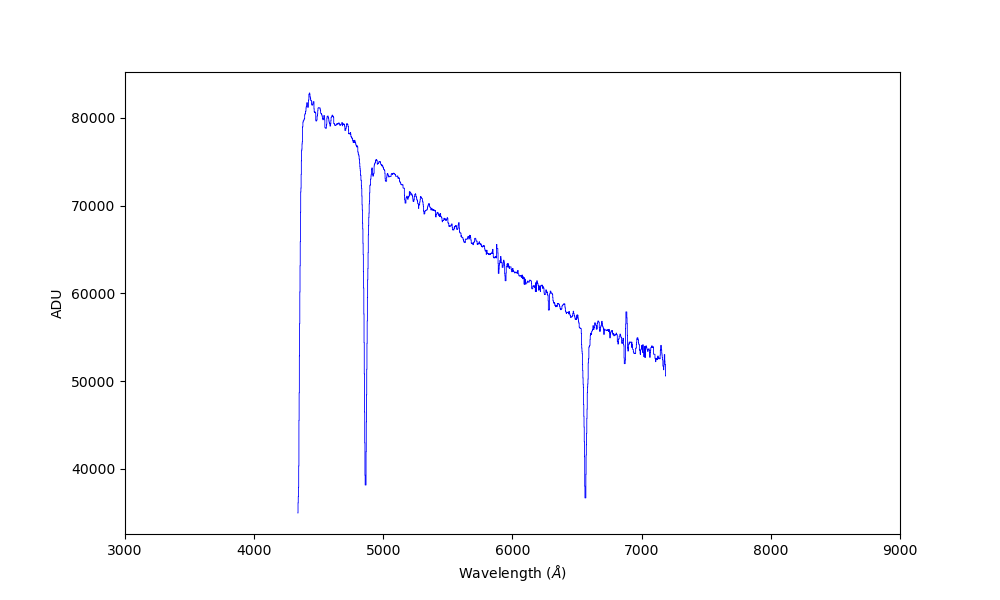

In [89]:
from specutils.manipulation import median_smooth

smooth_spec = median_smooth(final_spec, width=7) 

plt.figure(figsize=(10,6))
plt.xlim(3000, 9000)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.step(smooth_spec.wavelength, smooth_spec.flux, linewidth = '0.6', where="mid", color = 'b', label = 'science star');


### Show known lines

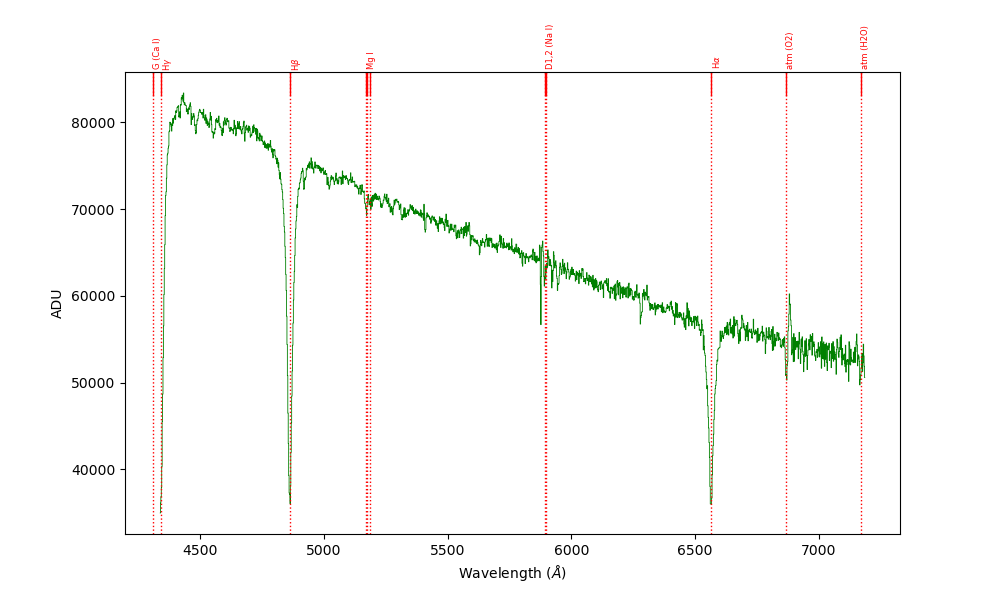

In [45]:
from spec_utils import show_lines
plt.figure(figsize = (10,6))
plt.step(final_spec.wavelength, final_spec.flux, color='green', linewidth = '0.6', where="mid")
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
#plt.ylim(-10000, 1e6)

show_lines(z = 0.0, ax = None, em_label = False, abs_label = True, rest_frame = True)


### Measure SNR

In [29]:
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils import SpectralRegion
from astropy.modeling import models, fitting
from specutils.analysis import snr, snr_derived
from specutils import Spectrum1D
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region

with fits.open(dir + 'final-1D-' + target + '.fit') as file:
    specdata = file[1].data
    header = file[1].header
    final_spec1d = Spectrum1D(flux = specdata['flux'] * u.mJy, spectral_axis = specdata['wavelength'] * u.AA)

print(f'snr = {snr_derived(final_spec1d)}')

snr = 130.08979602084304


### Remove continuum

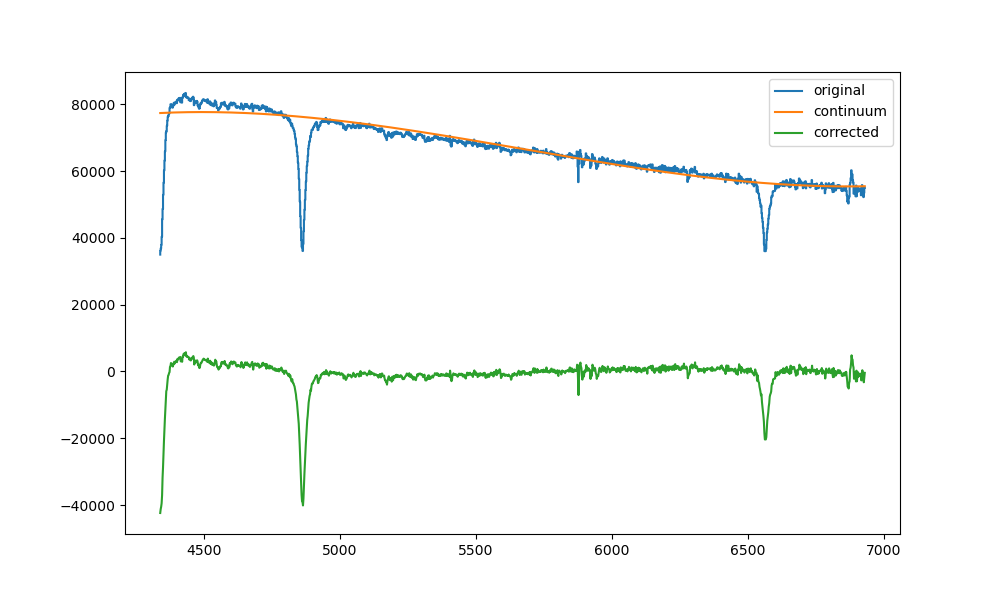

In [47]:
### extract continuum on a selected region

if True:
    region = SpectralRegion(3800*u.AA, 6930*u.AA)
    
    sub_spectra = extract_region(final_spec1d, region)
    
    generic_continuum = fit_generic_continuum(sub_spectra, exclude_regions = [
            SpectralRegion(3700 * u.AA, 4000 * u.AA),
             SpectralRegion(4825 * u.AA, 4885 * u.AA),
             SpectralRegion(4825 * u.AA, 5200 * u.AA),
             SpectralRegion(6400 * u.AA, 6800 * u.AA)
            ])
    #generic_continuum = fit_continuum(sub_spectra, models.Hermite1D(3))
    
    generic_continuum_evaluated = generic_continuum(sub_spectra.spectral_axis)
    
    spec_normalized = sub_spectra - generic_continuum_evaluated
    
    plt.figure(figsize = (10,6))
    plt.step(sub_spectra.spectral_axis, sub_spectra.flux)
    plt.plot(sub_spectra.spectral_axis, generic_continuum_evaluated)
    plt.plot(spec_normalized.spectral_axis, spec_normalized.flux)
    plt.legend(['original', 'continuum', 'corrected'], loc=('best'))
    #plt.xlim(4700, 5000)



### Identify lines

In [54]:
### identify lines
from specutils.fitting import find_lines_derivative
from specutils.fitting import fit_lines

if True:
    lines = find_lines_derivative(spec_normalized, flux_threshold=3000)
    print('emission: ', lines[lines['line_type'] == 'emission']) 
    print('absorption: ', lines[lines['line_type'] == 'absorption']) 


emission:     line_center     line_type line_center_index
     Angstrom                                 
------------------ --------- -----------------
 4410.656187409527  emission                42
 4426.089284296515  emission                51
4458.6857440288295  emission                70
  4474.13350373035  emission                79
 4498.172720064221  emission                93
 4513.632524220535  emission               102
 6880.588966823515  emission              1449
absorption:     line_center    line_type  line_center_index
     Angstrom                                 
----------------- ---------- -----------------
4861.859236715003 absorption               304
4918.973374383953 absorption               337
5168.940221871682 absorption               481
6561.752598129948 absorption              1271
6866.219676062921 absorption              1441


### Fit a line

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean             stddev      
           mJy             Angstrom          Angstrom     
    ----------------- ----------------- ------------------
    -18314.1268427079 6564.572120915666 12.470058419450009


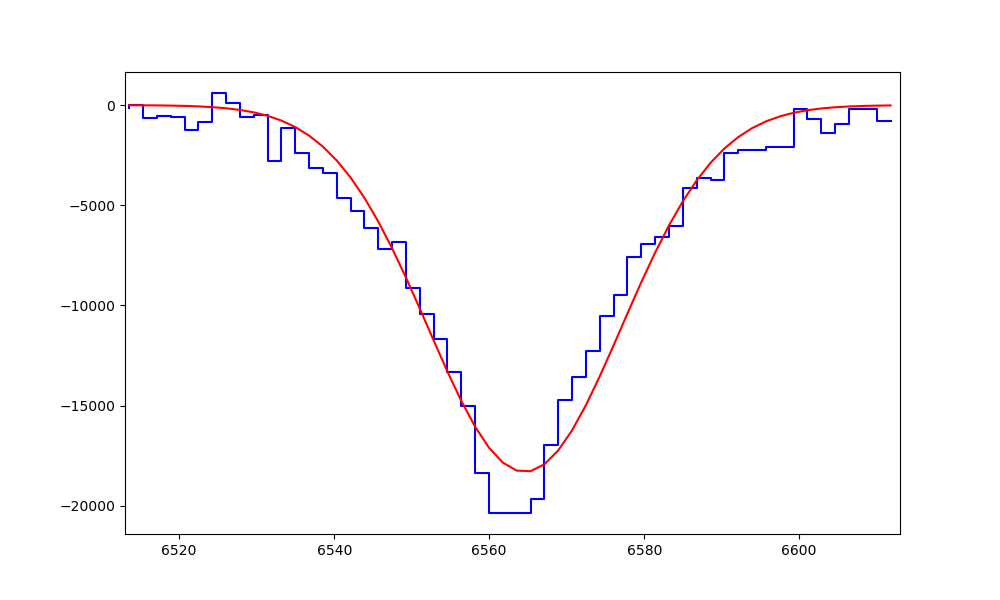

In [57]:
from specutils.manipulation import extract_region
from specutils.fitting import estimate_line_parameters
from specutils.analysis import centroid, fwhm
from specutils.fitting import fit_lines

if True:
    #lineAA = 5016
    lineAA = 6563
    sr =  SpectralRegion((lineAA-50)*u.AA, (lineAA+50)*u.AA)
    #sr =  SpectralRegion((lineAA-50)*u.AA, (lineAA+50)*u.AA)
    
    #create a new spectrum of the selected region for plot
    sub_spectrum = extract_region(spec_normalized, sr)
    Ha_line = Spectrum1D(flux = sub_spectrum.flux, spectral_axis = sub_spectrum.spectral_axis)
    
    line_estimate = models.Gaussian1D(mean = lineAA*u.AA, stddev = 2*u.AA, amplitude=40000)
    line_model = fit_lines(sub_spectrum, line_estimate)
    evaluated_model = line_model(sub_spectrum.wavelength)
    
    print(line_model)
    
    plt.figure(figsize = (10,6))
    #plt.step(reg_spectra.wavelength, reg_spectra.flux, label="Original spectrum")
    plt.step(Ha_line.spectral_axis, Ha_line.flux , label="original spectrum", color = 'b')
    plt.plot(Ha_line.spectral_axis, evaluated_model , label="Fit result", color = 'r')
    #plt.plot(Ha_line.spectral_axis, Ha_line.flux)
    plt.xlim(lineAA-50, lineAA+50)


### Measure line

In [58]:
### measure 
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import gaussian_sigma_width, gaussian_fwhm, fwhm, fwzi

if True:
    print(f'gaussian fwhm = {gaussian_fwhm(Ha_line)}' )
    center = centroid(spec_normalized, sr)  
    print(f'center = {center}')
    
    print(f'fwhm = {fwhm(Ha_line)}') 
    print(f'R = {(center / fwhm(Ha_line))}')
    print(f'fwzi = {fwzi(Ha_line)}') 
    
    print(f'line flux = {line_flux(Ha_line)}'  )
    
    #noisy_gaussian_with_continuum = noisy_gaussian + 1*u.Jy
    print(f'equivalent width = {equivalent_width(Ha_line)}')


gaussian fwhm = 34.80883451640446 Angstrom
center = 6565.044827485894 Angstrom
fwhm = 1.4663654488922475 Angstrom
R = 4477.086412834807
fwzi = 2.999999362267787 Angstrom
line flux = -602821.9136964057 Angstrom mJy
equivalent width = 602921.9333987696 Angstrom
